In [40]:
import torch
import os

os.chdir(r"C:\Users\cunn2\OneDrive\DSML\Project\thesis-repo")

run_path = r"sms/exp1/runs"

results = {}

for run in os.listdir(run_path):
    eval_path = os.path.join(run_path, run, "eval")
    run_results = {}
    for eval_file in os.listdir(eval_path):
        run_results[eval_file.replace('_eval.pt', '')] = torch.load(os.path.join(eval_path, eval_file))
    results[run] = run_results

C:\Users\cunn2\AppData\Local\Temp\ipykernel_31320\2423764498.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  run_results[eval_file.replace('_eval.pt', '')] = torch.load

In [2]:
def print_nested_keys(d, indent=0):
    for key, value in d.items():
        print('  ' * indent + str(key))
        if isinstance(value, dict):
            print_nested_keys(value, indent + 1)
        else:
            print('  ' * (indent + 1) + f"Type: {type(value)}")

In [3]:
print_nested_keys(results)

transformer_abs_1
  finetune_saved_model
    chunk_transposed
      top_k
        1
          recall
            Type: <class 'list'>
          avg_recall
            Type: <class 'numpy.float64'>
        3
          recall
            Type: <class 'list'>
          avg_recall
            Type: <class 'numpy.float64'>
        5
          recall
            Type: <class 'list'>
          avg_recall
            Type: <class 'numpy.float64'>
        10
          recall
            Type: <class 'list'>
          avg_recall
            Type: <class 'numpy.float64'>
        25
          recall
            Type: <class 'list'>
          avg_recall
            Type: <class 'numpy.float64'>
        50
          recall
            Type: <class 'list'>
          avg_recall
            Type: <class 'numpy.float64'>
        100
          recall
            Type: <class 'list'>
          avg_recall
            Type: <class 'numpy.float64'>
      radius
        dataset_proportion_in_radius
          

In [5]:
d = torch.load(r"data\exp2\embeddings\transformer_rel_1_pretrain_embeddings_0.pt")



C:\Users\cunn2\AppData\Local\Temp\ipykernel_189724\1250798058.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(r"data\exp2\embeddings\transformer_rel_1_pre

In [6]:
d['NLB126849_01.mid_chunk9_aug2'].keys()

NameError: name 'd' is not defined

In [6]:
results['transformer_abs_1']['finetune_saved_model']['chunk']

KeyError: 'chunk'

# seaborn

## top K search

In [31]:
results.keys()

dict_keys(['transformer_abs_1', 'transformer_pr_1', 'transformer_quant_abs_1', 'transformer_quant_rel_bigenc_1', 'transformer_rel_1', 'transformer_rel_big_1'])

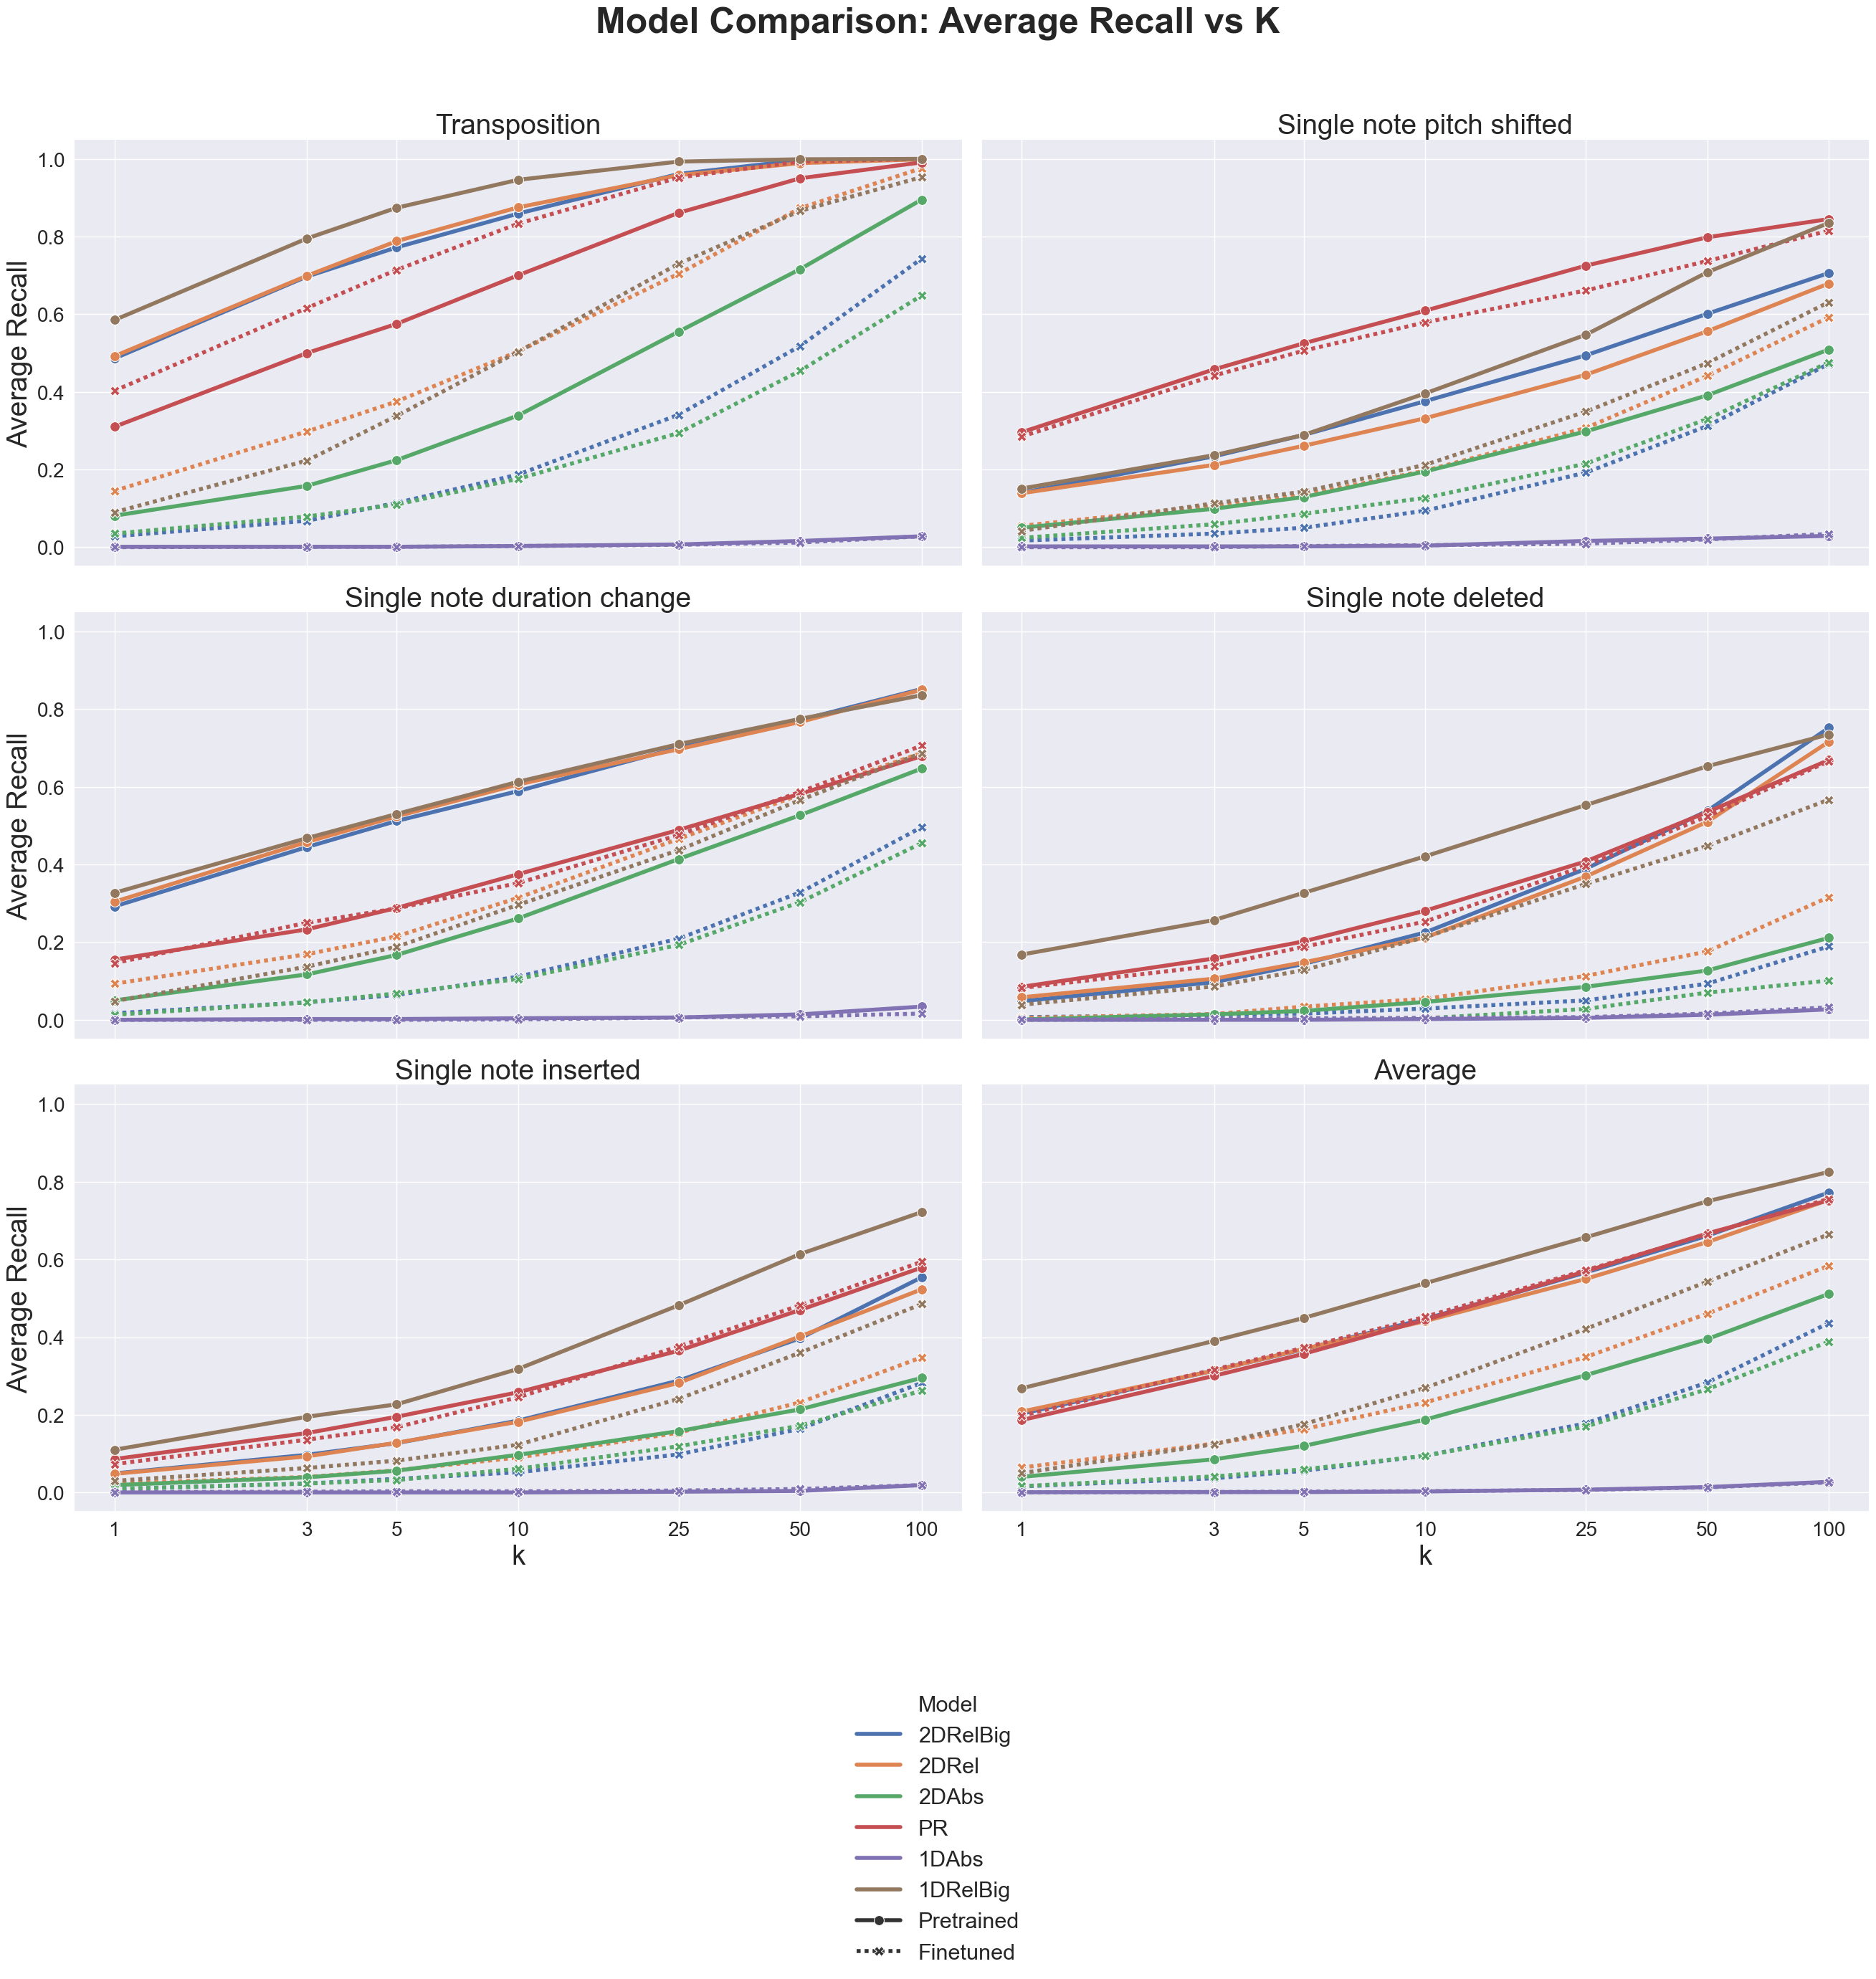

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def visualize_model_comparison_faceted(all_results, model_keys, k_list):
    # Prepare data for plotting
    data = []
    aug_type_mapping = {
        'chunk_transposed': 'Transposition',
        'chunk_one_pitch_shifted': 'Single note pitch shifted',  # Corrected typo
        'chunk_note_duration_changed': 'Single note duration change',
        'chunk_note_deleted': 'Single note deleted',
        'chunk_note_inserted': 'Single note inserted',
        'Average': 'Average'
    }
    
    for outer_key, inner_key, display_name, is_pretrained in model_keys:
        model_results = all_results[outer_key][inner_key]
        aug_types = [key for key in model_results.keys() if key != 'query_times']
        
        for aug_type in aug_types:
            for k in k_list:
                # Use get() method with a default value to handle missing keys
                aug_label = aug_type_mapping.get(aug_type, aug_type)
                data.append({
                    'Model': display_name,
                    'Pretrained': 'Pretrained' if is_pretrained else 'Finetuned',
                    'Augmentation': aug_label,
                    'k': k,
                    'Average Recall': model_results[aug_type]['top_k'][k]['avg_recall']
                })
        
        # Add average across all augmentations
        avg_recalls = []
        for k in k_list:
            recalls = [model_results[aug_type]['top_k'][k]['avg_recall'] for aug_type in aug_types]
            avg_recalls.append(np.mean(recalls))
        
        for k, recall in zip(k_list, avg_recalls):
            data.append({
                'Model': display_name,
                'Pretrained': 'Pretrained' if is_pretrained else 'Finetuned',
                'Augmentation': 'Average',
                'k': k,
                'Average Recall': recall
            })
    
    df = pd.DataFrame(data)
    
    # Set up the plot style
    sns.set_theme(style="darkgrid", font_scale=1.5)

    # Create the faceted plot with 3 rows and 2 columns
    g = sns.FacetGrid(df, col="Augmentation", col_wrap=2, height=8, aspect=1.5)
    
    # Plot the lines
    g.map_dataframe(sns.lineplot, x="k", y="Average Recall", hue="Model", 
                    style="Pretrained", markers=True, dashes=[(),(1,1)],
                    linewidth=4, markersize=10)
    
    # Customize the plot
    g.set_axis_labels("k", "Average Recall", fontsize=28)
    g.add_legend(bbox_to_anchor=(0.5, -0), loc='upper center', fontsize=22, title_fontsize=26)
    g.fig.suptitle('Model Comparison: Average Recall vs K', 
                   fontsize=36, y=0.97, weight='bold')  # Lowered the title and made it bold
    
    # Set x-axis to log scale and custom ticks
    for ax in g.axes.flat:
        ax.set_xscale('log')
        ax.set_xticks(k_list)
        ax.set_xticklabels(k_list, fontsize=20)
        ax.tick_params(axis='y', labelsize=20)
    
    # Manually set the font size for each subplot title and remove "Augmentation ="
    for ax in g.axes.flat:
        title = ax.get_title()
        new_title = title.replace("Augmentation = ", "")
        ax.set_title(new_title, fontsize=28)
    
    # Adjust layout and save
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjusted to make room for the legend
    plt.savefig("model_comparison_faceted_results.png", dpi=300, bbox_inches='tight')
    plt.show()

# Usage remains the same

# Usage remains the same
k_list = [1, 3, 5, 10, 25, 50, 100]
model_keys = [
    ('transformer_rel_big_1', 'pretrain_saved_model', '2DRelBig', True),
    ('transformer_rel_big_1', 'finetune_saved_model', '2DRelBig', False),
    ('transformer_rel_1', 'pretrain_saved_model', '2DRel', True),
    ('transformer_rel_1', 'finetune_saved_model', '2DRel', False),
    ('transformer_abs_1', 'pretrain_saved_model', '2DAbs', True),
    ('transformer_abs_1', 'finetune_saved_model', '2DAbs', False),
    ('transformer_pr_1', 'pretrain_saved_model', 'PR', True),
    ('transformer_pr_1', 'finetune_saved_model', 'PR', False),
    ('transformer_quant_abs_1', 'pretrain_saved_model', '1DAbs', True),
    ('transformer_quant_abs_1', 'finetune_saved_model', '1DAbs', False),
    ('transformer_quant_rel_bigenc_1', 'pretrain_saved_model', '1DRelBig', True),
    ('transformer_quant_rel_bigenc_1', 'finetune_saved_model', '1DRelBig', False),
]
visualize_model_comparison_faceted(results, model_keys, k_list)

In [41]:
import numpy as np

def generate_latex_table_avg_recall(all_results, model_keys, k_list):
    aug_types = ['chunk_transposed', 'chunk_one_pitch_shifted', 'chunk_note_duration_changed', 'chunk_note_deleted', 'chunk_note_inserted']
    
    latex_rows = []
    for outer_key, inner_key, display_name, is_pretrained in model_keys:
        model_results = all_results[outer_key][inner_key]
        row_values = []
        for k in k_list:
            avg_recalls = [model_results[aug_type]['top_k'][k]['avg_recall'] for aug_type in aug_types]
            overall_avg = np.mean(avg_recalls)
            row_values.append(f"{overall_avg:.3f}")
        
        model_name = f"{display_name} ({'Pretrained' if is_pretrained else 'Finetuned'})"
        latex_rows.append(f"{model_name} & {' & '.join(row_values)} \\\\")
    
    table_content = "\n\\hline\n".join(latex_rows)
    
    k_headers = ' & '.join([f"\\textbf{{k={k}}}" for k in k_list])
    
    latex_table = f"""
\\begin{{table}}[h]
\\centering
\\resizebox{{\\textwidth}}{{!}}{{%
\\begin{{tabular}}{{|l|{'c|' * len(k_list)}}}
\\hline
\\textbf{{Model}} & {k_headers} \\\\
\\hline
{table_content}
\\hline
\\end{{tabular}}
}}
\\caption{{Average Recall Across Augmentation Types for Different Models and K Values}}
\\label{{tab:model_comparison_k_values}}
\\end{{table}}
"""
    return latex_table

# Usage
k_list = [1, 3, 5, 10, 25, 50, 100]
model_keys = [
    ('transformer_rel_big_1', 'pretrain_saved_model', '2DRelBig', True),
    ('transformer_rel_big_1', 'finetune_saved_model', '2DRelBig', False),
    ('transformer_rel_1', 'pretrain_saved_model', '2DRel', True),
    ('transformer_rel_1', 'finetune_saved_model', '2DRel', False),
    ('transformer_abs_1', 'pretrain_saved_model', '2DAbs', True),
    ('transformer_abs_1', 'finetune_saved_model', '2DAbs', False),
    ('transformer_pr_1', 'pretrain_saved_model', 'PR', True),
    ('transformer_pr_1', 'finetune_saved_model', 'PR', False),
    ('transformer_quant_abs_1', 'pretrain_saved_model', '1DAbs', True),
    ('transformer_quant_abs_1', 'finetune_saved_model', '1DAbs', False),
    ('transformer_quant_rel_bigenc_1', 'pretrain_saved_model', '1DRelBig', True),
    ('transformer_quant_rel_bigenc_1', 'finetune_saved_model', '1DRelBig', False),
]

latex_table = generate_latex_table_avg_recall(results, model_keys, k_list)
print(latex_table)


\begin{table}[h]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{|l|c|c|c|c|c|c|c|}
\hline
\textbf{Model} & \textbf{k=1} & \textbf{k=3} & \textbf{k=5} & \textbf{k=10} & \textbf{k=25} & \textbf{k=50} & \textbf{k=100} \\
\hline
2DRelBig (Pretrained) & 0.203 & 0.314 & 0.369 & 0.447 & 0.567 & 0.661 & 0.773 \\
\hline
2DRelBig (Finetuned) & 0.016 & 0.037 & 0.056 & 0.095 & 0.178 & 0.283 & 0.436 \\
\hline
2DRel (Pretrained) & 0.208 & 0.314 & 0.370 & 0.441 & 0.550 & 0.645 & 0.753 \\
\hline
2DRel (Finetuned) & 0.064 & 0.126 & 0.163 & 0.232 & 0.349 & 0.460 & 0.584 \\
\hline
2DAbs (Pretrained) & 0.040 & 0.085 & 0.120 & 0.188 & 0.302 & 0.395 & 0.511 \\
\hline
2DAbs (Finetuned) & 0.016 & 0.041 & 0.060 & 0.095 & 0.170 & 0.266 & 0.388 \\
\hline
PR (Pretrained) & 0.186 & 0.300 & 0.357 & 0.445 & 0.570 & 0.667 & 0.753 \\
\hline
PR (Finetuned) & 0.198 & 0.317 & 0.373 & 0.452 & 0.572 & 0.665 & 0.756 \\
\hline
1DAbs (Pretrained) & 0.001 & 0.001 & 0.001 & 0.003 & 0.007 & 0.014 & 0.027 \\
\hline
1DAbs

# radius vis

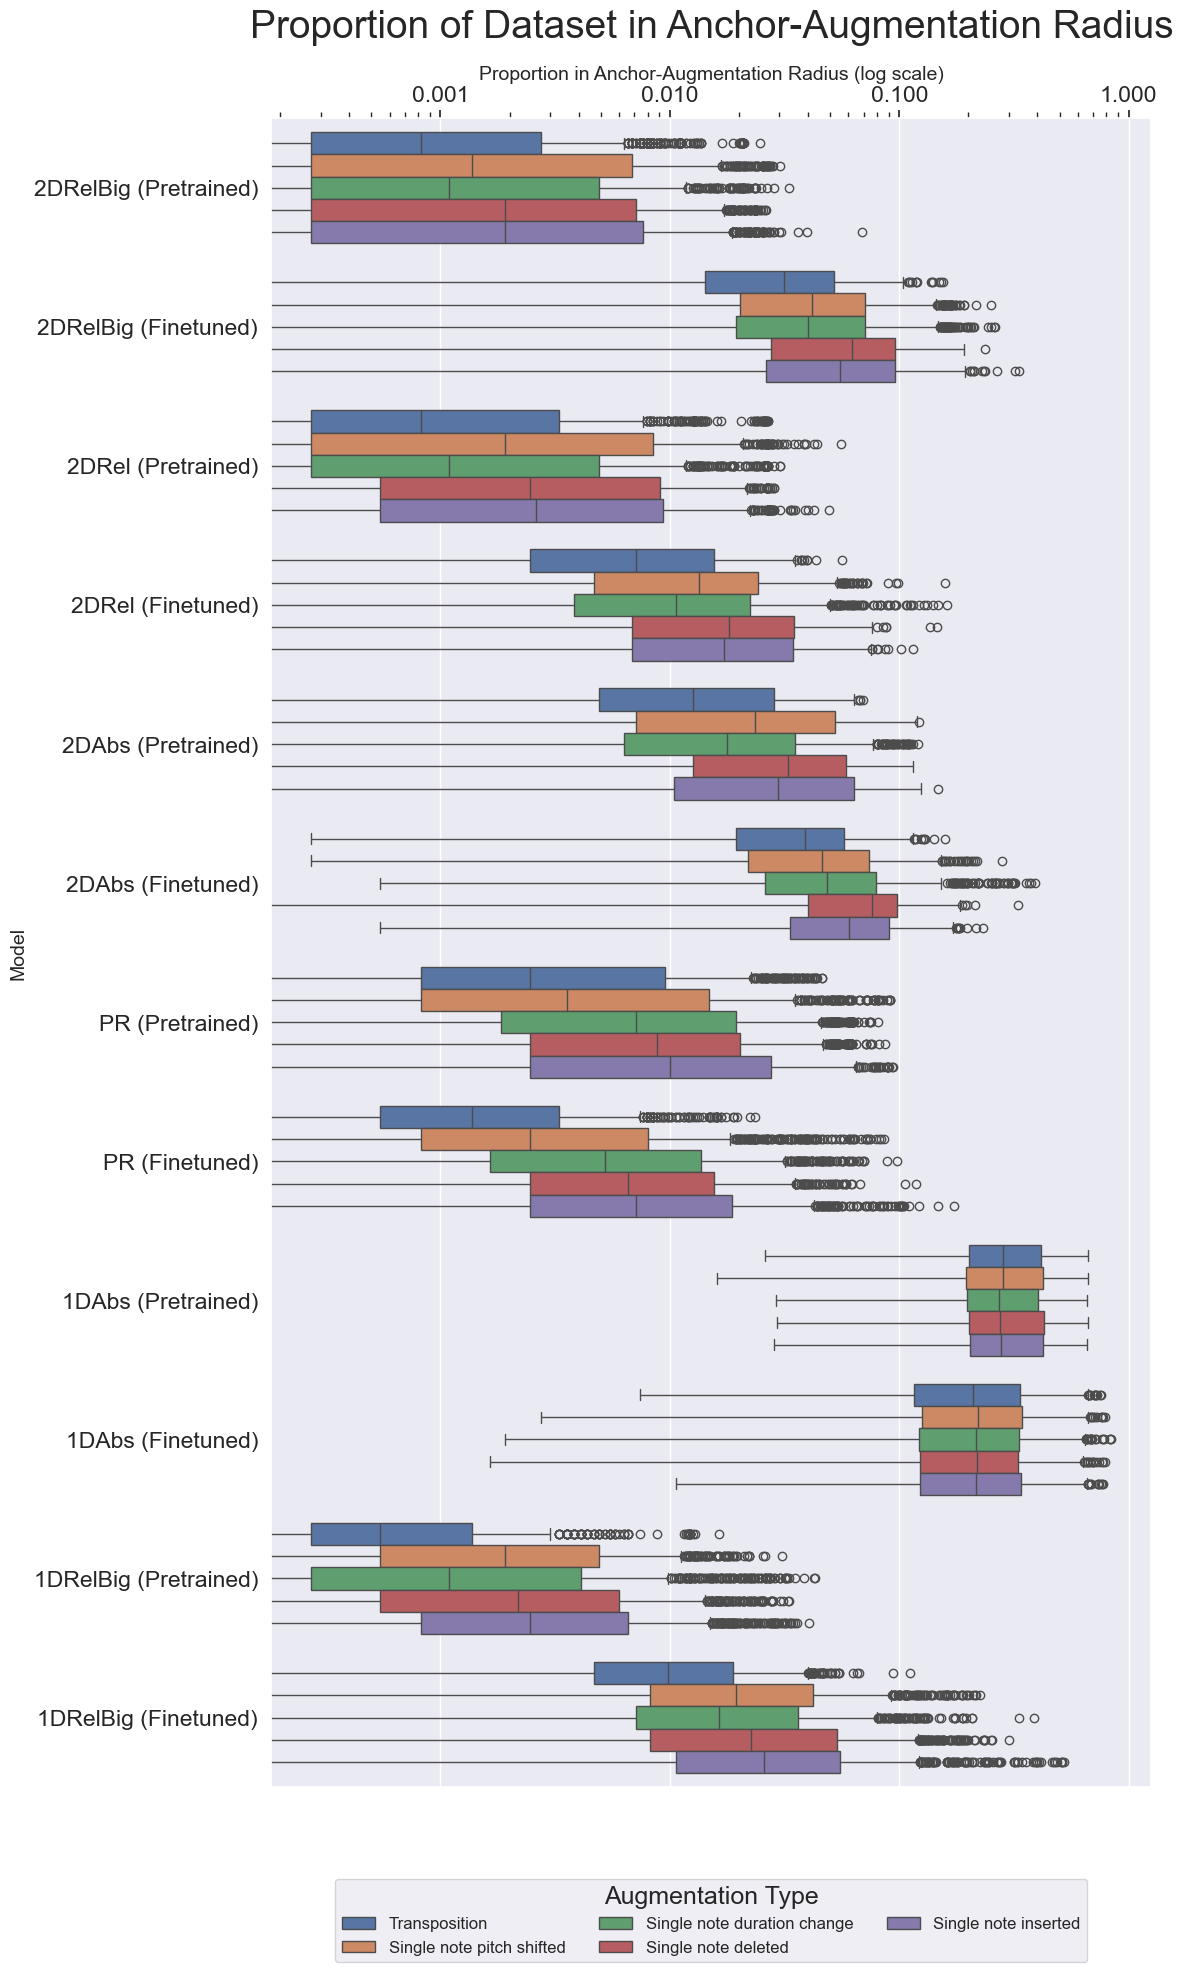

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def visualize_radius_search_comparison(all_results, model_keys):
    """
    Create a single large plot with horizontal boxplots for dataset proportion in radius
    for different augmentation types, models, and their pretrained/finetuned versions.
    
    Args:
        all_results: Dictionary of results for each model
        model_keys: List of tuples, each containing (outer_key, inner_key, display_name, is_pretrained)
    """
    # Prepare data for plotting
    data = []
    aug_type_mapping = {
        'chunk_transposed': 'Transposition',
        'chunk_one_pitch_shifted': 'Single note pitch shifted',
        'chunk_note_duration_changed': 'Single note duration change',
        'chunk_note_deleted': 'Single note deleted',
        'chunk_note_inserted': 'Single note inserted',
        'Average': 'Average'
    }
    for outer_key, inner_key, display_name, is_pretrained in model_keys:
        model_results = all_results[outer_key][inner_key]
        aug_types = [key for key in model_results.keys() if key != 'query_times']
        
        for aug_type in aug_types:
            percentages = model_results[aug_type]['radius']['dataset_proportion_in_radius']
            data.extend([{
                'Model': f"{display_name} ({'Pretrained' if is_pretrained else 'Finetuned'})",
                'Augmentation': aug_type_mapping.get(aug_type, aug_type),
                'Proportion in Radius': p
            } for p in percentages])
    
    df = pd.DataFrame(data)
    
    # Set up the plot style
    sns.set_style("darkgrid")
    plt.figure(figsize=(12, 20))
    
    # Create the horizontal boxplot with logarithmic x-axis
    ax = sns.boxplot(x="Proportion in Radius", y="Model", hue="Augmentation", 
                     data=df, orient="h", palette="deep")
    
    # Set x-axis to logarithmic scale
    ax.set_xscale('log')
    
    # Customize the plot
    plt.title('Proportion of Dataset in Anchor-Augmentation Radius', 
              fontsize=28, pad=20)
    plt.xlabel("Proportion in Anchor-Augmentation Radius (log scale)", fontsize=14)
    plt.ylabel("Model", fontsize=14)
    
    # Move x-axis to the top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    # Set x-axis ticks to use notation like 0.001 instead of 10^-3
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.3f}"))
    
    # Adjust legend
    plt.legend(title="Augmentation Type", bbox_to_anchor=(0.5, -0.05), 
               loc='upper center', ncol=3, fontsize=12)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig("radius_search_comparison_results.png", dpi=300, bbox_inches='tight')
    plt.show()

# Usage remains the same
model_keys = [
    ('transformer_rel_big_1', 'pretrain_saved_model', '2DRelBig', True),
    ('transformer_rel_big_1', 'finetune_saved_model', '2DRelBig', False),
    ('transformer_rel_1', 'pretrain_saved_model', '2DRel', True),
    ('transformer_rel_1', 'finetune_saved_model', '2DRel', False),
    ('transformer_abs_1', 'pretrain_saved_model', '2DAbs', True),
    ('transformer_abs_1', 'finetune_saved_model', '2DAbs', False),
    ('transformer_pr_1', 'pretrain_saved_model', 'PR', True),
    ('transformer_pr_1', 'finetune_saved_model', 'PR', False),
    ('transformer_quant_abs_1', 'pretrain_saved_model', '1DAbs', True),
    ('transformer_quant_abs_1', 'finetune_saved_model', '1DAbs', False),
    ('transformer_quant_rel_bigenc_1', 'pretrain_saved_model', '1DRelBig', True),
    ('transformer_quant_rel_bigenc_1', 'finetune_saved_model', '1DRelBig', False),
]
visualize_radius_search_comparison(results, model_keys)

In [36]:
import pandas as pd
import numpy as np

def generate_latex_table_radius(all_results, model_keys):
    aug_type_mapping = {
        'chunk_transposed': 'Transposition',
        'chunk_one_pitch_shifted': 'Single note pitch shifted',
        'chunk_note_duration_changed': 'Single note duration change',
        'chunk_note_deleted': 'Single note deleted',
        'chunk_note_inserted': 'Single note inserted'
    }
    
    latex_rows = []
    for outer_key, inner_key, display_name, is_pretrained in model_keys:
        model_results = all_results[outer_key][inner_key]
        row_values = []
        for aug_type in aug_type_mapping.keys():
            percentages = model_results[aug_type]['radius']['dataset_proportion_in_radius']
            median_proportion = np.median(percentages)
            row_values.append(f"{median_proportion:.3f}")
        
        model_name = f"{display_name} ({'Pretrained' if is_pretrained else 'Finetuned'})"
        latex_rows.append(f"{model_name} & {' & '.join(row_values)} \\\\")
    
    table_content = "\n\\hline\n".join(latex_rows)
    
    latex_table = f"""
\\begin{{table}}[h]
\\centering
\\resizebox{{\\textwidth}}{{!}}{{%
\\begin{{tabular}}{{|l|c|c|c|c|c|}}
\\hline
\\textbf{{Model}} & \\textbf{{Transposition}} & \\textbf{{Single note pitch shifted}} & \\textbf{{Single note duration change}} & \\textbf{{Single note deleted}} & \\textbf{{Single note inserted}} \\\\
\\hline
{table_content}
\\hline
\\end{{tabular}}
}}
\\caption{{Median Proportion of Dataset in Anchor-Augmentation Radius for Different Models and Augmentation Types}}
\\label{{tab:radius_comparison}}
\\end{{table}}
"""
    return latex_table

# Generate and print the LaTeX table
latex_table = generate_latex_table_radius(results, model_keys)
print(latex_table)


\begin{table}[h]
\centering
\resizebox{\textwidth}{!}{%
\begin{tabular}{|l|c|c|c|c|c|}
\hline
\textbf{Model} & \textbf{Transposition} & \textbf{Single note pitch shifted} & \textbf{Single note duration change} & \textbf{Single note deleted} & \textbf{Single note inserted} \\
\hline
2DRelBig (Pretrained) & 0.001 & 0.001 & 0.001 & 0.002 & 0.002 \\
\hline
2DRelBig (Finetuned) & 0.032 & 0.042 & 0.040 & 0.062 & 0.055 \\
\hline
2DRel (Pretrained) & 0.001 & 0.002 & 0.001 & 0.002 & 0.003 \\
\hline
2DRel (Finetuned) & 0.007 & 0.013 & 0.011 & 0.018 & 0.017 \\
\hline
2DAbs (Pretrained) & 0.013 & 0.024 & 0.018 & 0.033 & 0.030 \\
\hline
2DAbs (Finetuned) & 0.039 & 0.046 & 0.049 & 0.076 & 0.060 \\
\hline
PR (Pretrained) & 0.002 & 0.004 & 0.007 & 0.009 & 0.010 \\
\hline
PR (Finetuned) & 0.001 & 0.002 & 0.005 & 0.007 & 0.007 \\
\hline
1DAbs (Pretrained) & 0.283 & 0.284 & 0.271 & 0.276 & 0.278 \\
\hline
1DAbs (Finetuned) & 0.210 & 0.221 & 0.217 & 0.217 & 0.216 \\
\hline
1DRelBig (Pretrained) & 0.001 &